# MPC super-ses

1. Intensity profiles 7T single session
2. Intensity profiles 7T SUPER session
3. qT1map midthickness 7T single session
4. qT1map midthickness 7T SUPER session
5. MPC colum mean 7T single session
6. MPC colum mean 7T SUPER session
7. MPC DM gradients 7T single session
8. MPC DM gradients 7T SUPER session

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from brainstat.datasets.base import combine_surfaces
import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_10k != 0


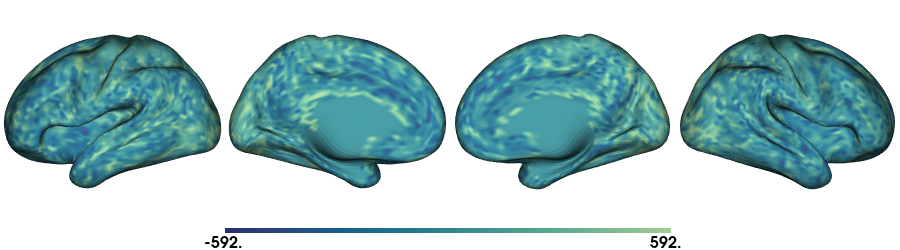

In [4]:
mpc_file = '/data/mica3/BIDS_PNI/SuperSession/data/derivatives/micapipe_v0.2.0/sub-PNC002/ses-post/mpc/acq-qMRI/sub-PNC002_ses-post_surf-fsLR-5k_desc-MPC.shape.gii'
mpc = nb.load(mpc_file).darrays[0].data
mpc = np.triu(mpc,1)+mpc.T
mpc[~np.isfinite(mpc)] = np.finfo(float).eps
mpc[mpc==0] = np.finfo(float).eps
deg = np.sum(mpc,axis=1)


plot_hemispheres(inf_lh, inf_rh, array_name=deg, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), cmap='crest_r', color_range='sym', transparent_bg=False, screenshot = False)


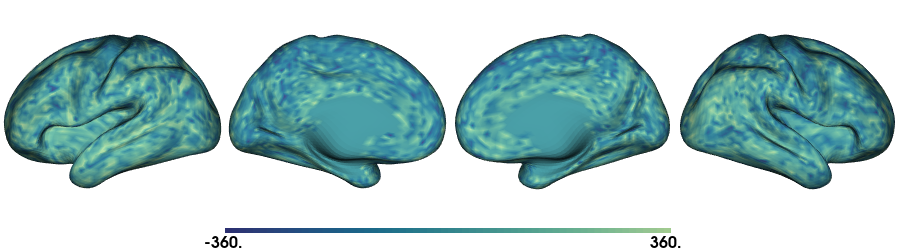

In [5]:
mpc_file1 = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC002/ses-01/mpc/acq-T1map/sub-PNC002_ses-01_surf-fsLR-5k_desc-MPC.shape.gii'
mpc1 = nb.load(mpc_file1).darrays[0].data
mpc1 = np.triu(mpc1,1)+mpc1.T
mpc1[~np.isfinite(mpc1)] = np.finfo(float).eps
mpc1[mpc1==0] = np.finfo(float).eps
deg1 = np.sum(mpc1,axis=1)


plot_hemispheres(inf_lh, inf_rh, array_name=deg1, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), cmap='crest_r', color_range='sym', transparent_bg=False, screenshot = False)


In [7]:
# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g
        grad[i] = g_nan
    
    return(MPCgm, grad)

In [13]:
# Calculate the gradients
Ngrad=3
MPC_all, grad = mpc_dm(mpc, mask_surf, Ngrad=Ngrad)

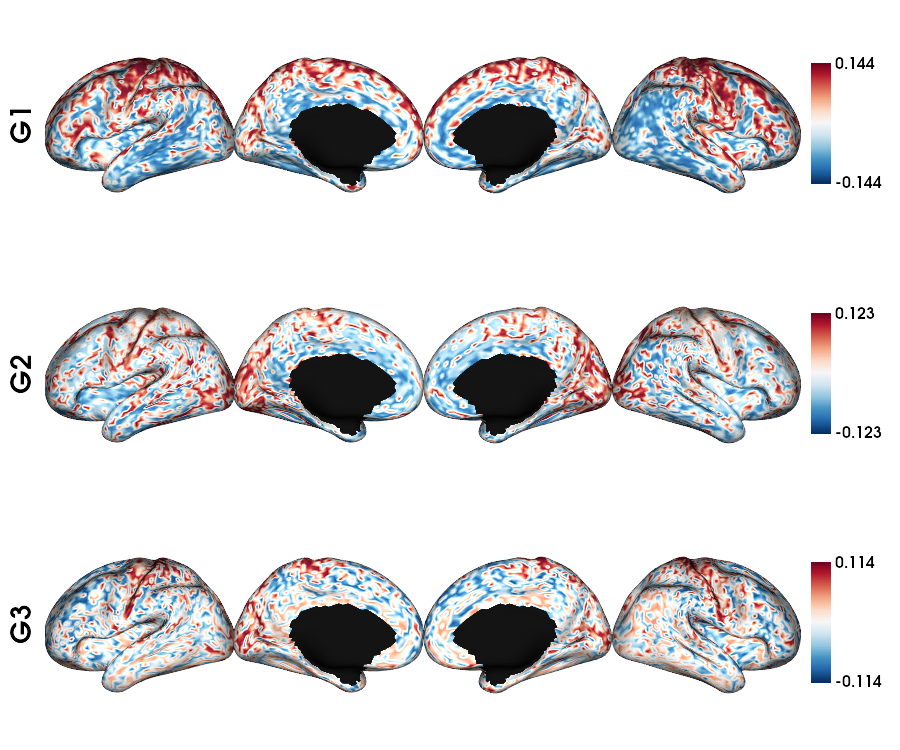

In [14]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [15]:
# Calculate the gradients
MPC_1, grad = mpc_dm(mpc1, mask_surf, Ngrad=Ngrad)

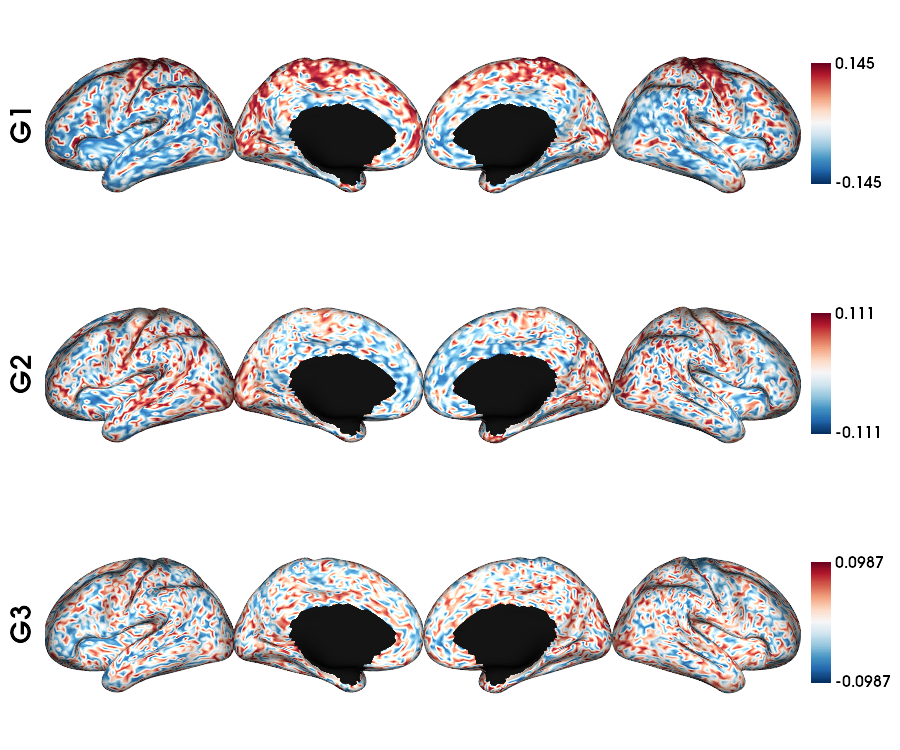

In [16]:
# plot the gradients
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)